In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, Conv1D, Flatten, MaxPooling1D

In [2]:
data= pd.read_csv(r"C:\Users\hsynt\Downloads\Selcuk Abi\Selcuk Abi\VeriSeti2.csv")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


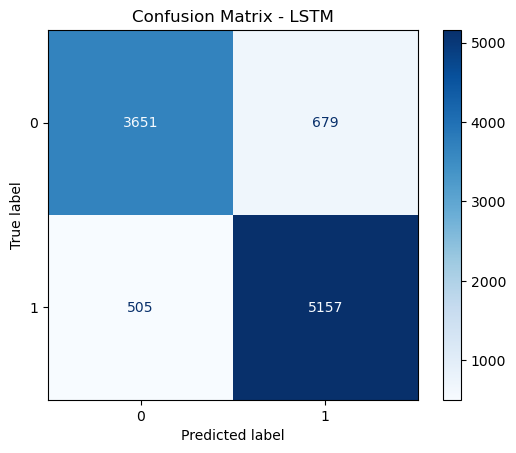

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


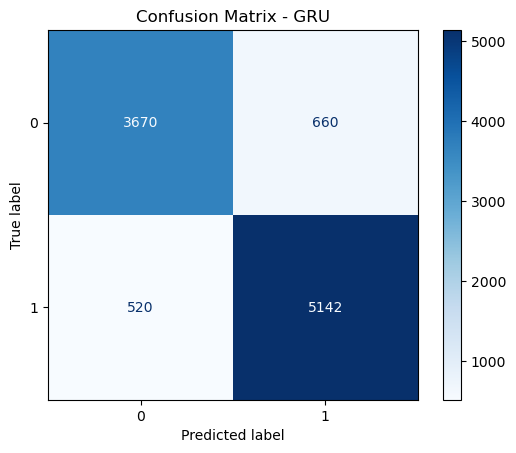

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


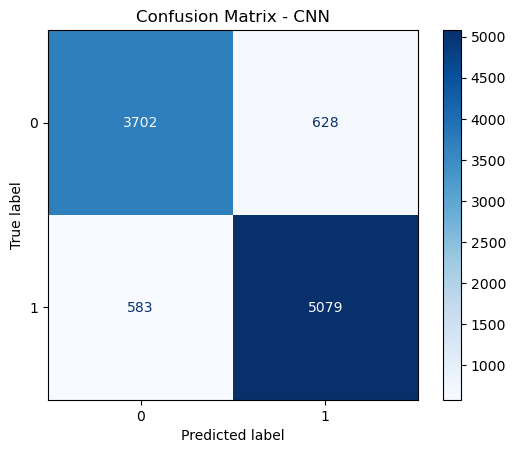

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step


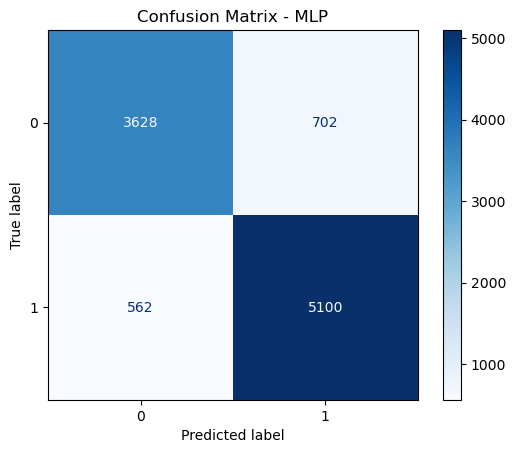

1249/1249 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


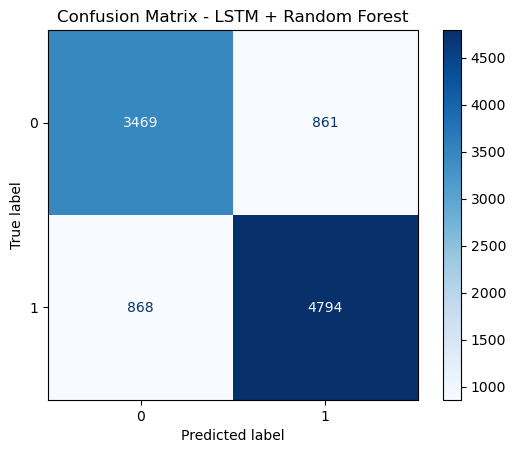

TP, TN, FP, FN Değerleri:
                        TP    TN   FP   FN
LSTM                  5157  3651  679  505
GRU                   5142  3670  660  520
CNN                   5079  3702  628  583
MLP                   5100  3628  702  562
LSTM + Random Forest  4794  3469  861  868


In [3]:
# Özellik ve hedef ayrımı
X = data.drop(columns=['Target_10', 'adjclose'])
y = data['Target_10']

# Zaman serisi formatına getirme
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

SEQ_LENGTH = 10
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_seq = create_sequences(X_scaled, SEQ_LENGTH)
y_seq = y[SEQ_LENGTH:].values

# Eğitim ve test kümesi ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

# Modellerin tanımları
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GRU(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_mlp_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Eğitim ve değerlendirme için model tahminlerini alıyoruz
models = {
    "LSTM": build_lstm_model(X_train.shape[1:]),
    "GRU": build_gru_model(X_train.shape[1:]),
    "CNN": build_cnn_model(X_train.shape[1:]),
    "MLP": build_mlp_model(X_train.shape[1] * X_train.shape[2])
}

# LSTM + Random Forest Modeli için ayrı özellik çıkarma ve eğitim
results = {}

for model_name, model in models.items():
    if model_name == "MLP":
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        model.fit(X_train_flat, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred = (model.predict(X_test_flat) > 0.5).astype("int32").flatten()
    else:
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()

    # Confusion Matrix Hesaplama
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Sonuçları kaydetme
    results[model_name] = {"TP": tp, "TN": tn, "FP": fp, "FN": fn}

    # Confusion Matrix Görselleştirme
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# LSTM + Random Forest Modeli
lstm_model = build_lstm_model(X_train.shape[1:])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
X_train_features = lstm_model.predict(X_train)
X_test_features = lstm_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_features, y_train)
y_pred_rf = rf_model.predict(X_test_features)

cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

results["LSTM + Random Forest"] = {"TP": tp_rf, "TN": tn_rf, "FP": fp_rf, "FN": fn_rf}

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LSTM + Random Forest")
plt.show()

# Sonuçları bir DataFrame'e dönüştürme
results_df = pd.DataFrame.from_dict(results, orient="index")
print("TP, TN, FP, FN Değerleri:")
print(results_df)

# Sonuçları CSV olarak kaydetme
results_df.to_csv("Confusion_Matrix_Results_All_Models.csv")